# Initialize

In [1]:
import os
init=False

# Imports

In [2]:
if not init:
    os.chdir('..')
    init=True
from pythonfigures.datapartition import DataPartitioner
from pythonfigures.neuraldatabase import Query
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import LeaveOneOut, BaseCrossValidator
from scipy.linalg import subspace_angles, orth

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

from typing import Optional

# Query Fixation, Cue, and Movement period data, show they're all orthogonalizable

In [3]:
dp = DataPartitioner(session='Zara70',
                    areas=['AIP'],
                    aligns=['fixation','cue onset','go cue onset','movement onset','hold'],
                    contexts=['active','passive'],
                    groupings=['context','alignment','grip','object','turntable','time'])

print( dp.get('groupings') )

[[], ['context'], ['alignment'], ['context', 'alignment'], ['grip'], ['context', 'grip'], ['alignment', 'grip'], ['context', 'alignment', 'grip'], ['object'], ['context', 'object'], ['alignment', 'object'], ['context', 'alignment', 'object'], ['grip', 'object'], ['context', 'grip', 'object'], ['alignment', 'grip', 'object'], ['context', 'alignment', 'grip', 'object'], ['turntable'], ['context', 'turntable'], ['alignment', 'turntable'], ['context', 'alignment', 'turntable'], ['grip', 'turntable'], ['context', 'grip', 'turntable'], ['alignment', 'grip', 'turntable'], ['context', 'alignment', 'grip', 'turntable'], ['object', 'turntable'], ['context', 'object', 'turntable'], ['alignment', 'object', 'turntable'], ['context', 'alignment', 'object', 'turntable'], ['grip', 'object', 'turntable'], ['context', 'grip', 'object', 'turntable'], ['alignment', 'grip', 'object', 'turntable'], ['context', 'alignment', 'grip', 'object', 'turntable'], ['time'], ['context', 'time'], ['alignment', 'time'],

In [4]:
# query the whole damn thing
df = dp.readQuery(0)

# convert from turntable x object ID vs. just the turntable ID
df['turntable'] = df['turntable'] // 10

print(df)

         n0        n1   n2   n3   n4   n5        n6        n7        n8   n9  \
0       0.0  0.093237  0.0  0.0  0.0  0.0  0.133653  0.015111  0.393682  0.0   
1       0.0  0.061866  0.0  0.0  0.0  0.0  0.188941  0.008631  0.397735  0.0   
2       0.0  0.039524  0.0  0.0  0.0  0.0  0.256995  0.004737  0.409651  0.0   
3       0.0  0.024301  0.0  0.0  0.0  0.0  0.336347  0.002498  0.429751  0.0   
4       0.0  0.014378  0.0  0.0  0.0  0.0  0.423572  0.001265  0.457440  0.0   
...     ...       ...  ...  ...  ...  ...       ...       ...       ...  ...   
189595  0.0  0.088819  0.0  0.0  0.0  0.0  0.642498  0.000000  0.174741  0.0   
189596  0.0  0.059543  0.0  0.0  0.0  0.0  0.671860  0.000000  0.156003  0.0   
189597  0.0  0.038364  0.0  0.0  0.0  0.0  0.681889  0.000000  0.136226  0.0   
189598  0.0  0.023778  0.0  0.0  0.0  0.0  0.671674  0.000000  0.116920  0.0   
189599  0.0  0.014226  0.0  0.0  0.0  0.0  0.642016  0.000000  0.099724  0.0   

        ...      n118  n119      n120  

## Analysis Notes:
* look for the subspace that preferentially expresses fixation-period data and delete it
* why not just do dPCA? because dPCA does not admit mutually orthogonal subspaces!
* instead, you'll want to do hypothesis-driven dimensionality reduction
* you may need to use pymanopt to this end
* and sweep through dimensionality assignments!
* but that's a complicated analysis for another day...

## Focus on this for now:
1. Extract fixation-period baseline effects and determine their subspace
2. Extract (sustained) visual-period activity, determine its subspace
3. Extract movement-period activity, determine ITS subspace
4. Justification? Orthogonalization is computationally straightforward (you get to claim 'this is how the brain extracts this info'), data partitioning is not (you don't get to easily claim 'this is how the brain is doing things')
5. Do a battery of subspace-matching analyses
    1. Discovery of 1-to-1 matched patterns (to prove the need for orthogonalization) (needs pymanopt)
    2. Discovery of subspace distance (principal angles, alignment index)
    3. Decoding analysis applied to the raw data (self- and cross-decoding)

In [5]:
# get baseline effects (i.e., before even fixation)
df_fixation = df[(df['alignment']=='fixation') & (df['time']<0)].groupby(['context','turntable','object'])[dp.get('neuronColumnNames')].aggregate('mean')

# get vision-period effects (i.e., after cue onset)
df_vision = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object'])[dp.get('neuronColumnNames')].aggregate('mean')

# get movement-period effects (post-movement onset, skip the preparatory activity which is more grip-agnostic than the movement-period activity per se, at least in M1)
df_movement = df[(df['alignment']=='movement onset') & (df['time']>0)].groupby(['context','turntable','object'])[dp.get('neuronColumnNames')].aggregate('mean')

In [6]:
print(df_fixation)

                                              n0        n1        n2  \
context turntable object                                               
active  1         Ball 15 mm        3.846718e-05  0.158330  0.039361   
                  Ball 30 mm        4.434195e-04  0.212902  0.020750   
                  Bar 10 mm         3.322811e-03  0.225598  0.076520   
                  Cube 30 mm        2.284735e-02  0.279065  0.039666   
                  Cylinder H 30 mm  6.539586e-04  0.209799  0.026225   
                  Ring 50 mm        0.000000e+00  0.281556  0.038910   
        2         Ring 10 mm        3.999618e-04  0.247138  0.034980   
                  Ring 20 mm        1.062612e-01  0.275802  0.041511   
                  Ring 30 mm        3.692012e-03  0.220930  0.027679   
                  Ring 40 mm        1.034196e-03  0.199540  0.048284   
                  Ring 50 mm        0.000000e+00  0.192754  0.120177   
                  Ring 60 mm        5.165993e-02  0.200447  0.02

In [7]:
print(df_vision)

                                              n0        n1        n2  \
context turntable object                                               
active  1         Ball 15 mm        0.000000e+00  0.069709  0.026026   
                  Ball 30 mm        2.110854e-02  0.144348  0.000089   
                  Bar 10 mm         0.000000e+00  0.033470  0.002190   
                  Cube 30 mm        0.000000e+00  0.128680  0.036062   
                  Cylinder H 30 mm  0.000000e+00  0.018755  0.000720   
                  Ring 50 mm        0.000000e+00  0.090530  0.012081   
        2         Ring 10 mm        0.000000e+00  0.125348  0.000004   
                  Ring 20 mm        0.000000e+00  0.130727  0.064398   
                  Ring 30 mm        5.094717e-03  0.110820  0.054544   
                  Ring 40 mm        0.000000e+00  0.092846  0.039527   
                  Ring 50 mm        2.349249e-04  0.069496  0.036680   
                  Ring 60 mm        1.436705e-07  0.108189  0.05

In [8]:
print(df_movement)

                                              n0        n1        n2  \
context turntable object                                               
active  1         Ball 15 mm        0.000000e+00  0.360083  0.054348   
                  Ball 30 mm        0.000000e+00  0.322284  0.098234   
                  Bar 10 mm         2.832058e-02  0.103335  0.077827   
                  Cube 30 mm        7.734580e-02  0.169579  0.068462   
                  Cylinder H 30 mm  1.953625e-05  0.087287  0.091146   
                  Ring 50 mm        1.034196e-03  0.108009  0.054701   
        2         Ring 10 mm        2.739534e-02  0.298364  0.130005   
                  Ring 20 mm        2.893607e-02  0.078511  0.114802   
                  Ring 30 mm        3.219295e-02  0.093085  0.162099   
                  Ring 40 mm        3.846718e-05  0.055611  0.101528   
                  Ring 50 mm        0.000000e+00  0.055039  0.099410   
                  Ring 60 mm        1.333500e-04  0.075204  0.17

In [9]:
# convert to numpy
np_fixation = df_fixation.to_numpy()

np_vision = df_vision.to_numpy()

np_movement = dict()
np_movement['active'] = df_movement.loc['active'].to_numpy()
np_movement['passive'] = df_movement.loc['passive'].to_numpy()

In [10]:
# PCA
# note: 'mle' uses Minka's mle method
# here's the review that justifies it: https://www.mdpi.com/2227-7390/9/22/2840
# (but this tends to just extract *all* the dimensions...)
# but when there are more features than observations, we just use 'None' with the 'arpack' solver (get rid of the last component, which explains a singular data dimension)
pca_fixation = PCA(n_components=2).fit(np_fixation)

pca_vision = PCA(n_components=2).fit(np_vision)

pca_movement = dict()
pca_movement['active'] = PCA(n_components=2).fit(np_movement['active'])
pca_movement['passive'] = PCA(n_components=2).fit(np_movement['passive'])

In [11]:
# plot the top 2 components of each
x_fixation = pca_fixation.transform(np_fixation)

x_vision = pca_vision.transform(np_vision)

x_movement_on_viz = dict()
x_movement_on_viz['active'] = pca_vision.transform(np_movement['active']) # pca_movement['active'].transform(np_movement['active'])
x_movement_on_viz['passive'] = pca_vision.transform(np_movement['passive']) # pca_movement['passive'].transform(np_movement['passive'])

x_movement = dict()
x_movement['active'] = pca_movement['active'].transform(np_movement['active'])
x_movement['passive'] = pca_movement['passive'].transform(np_movement['passive'])

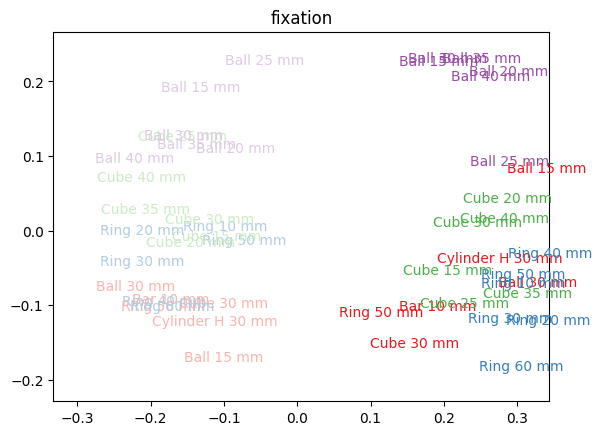

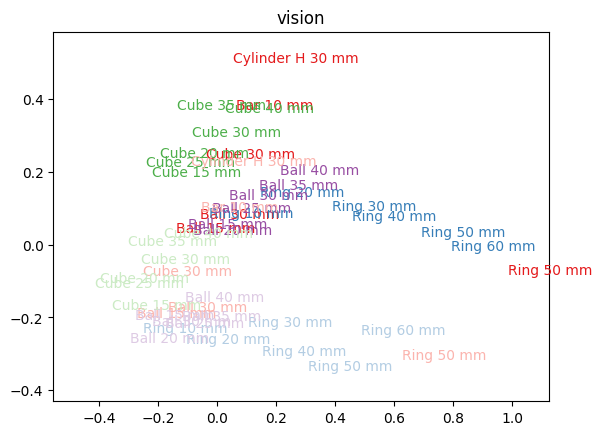

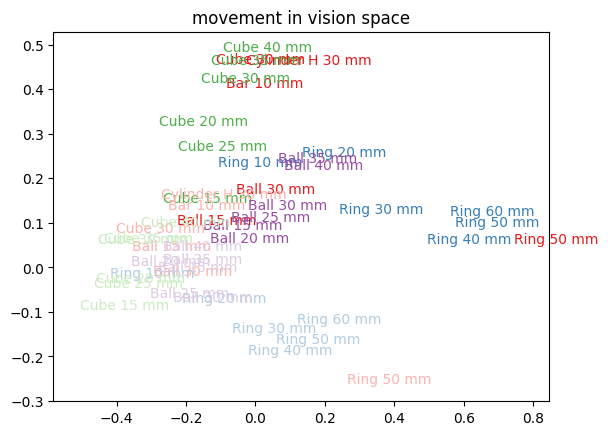

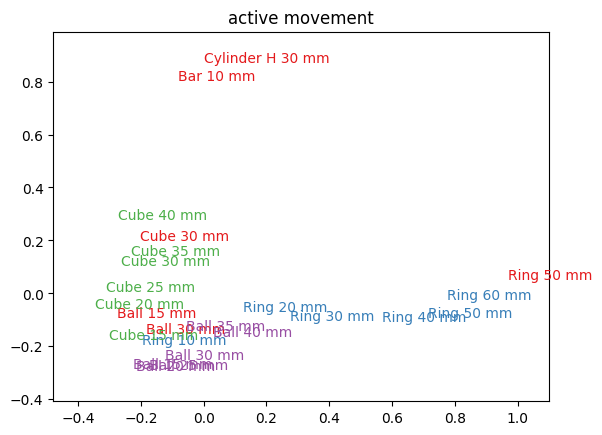

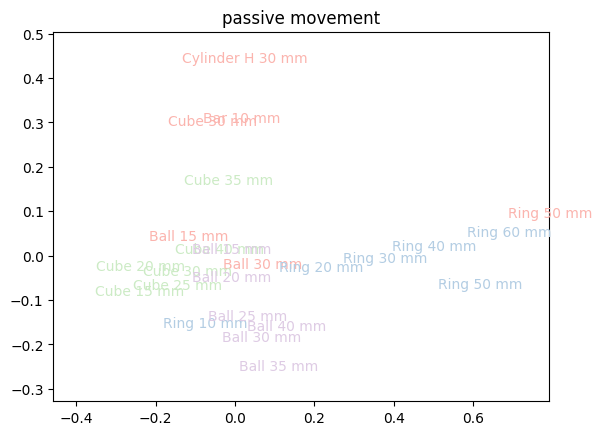

In [12]:
# plot the first 2 PCs

# fixation:
index_levels      = df_fixation.index.to_list()
unique_turntables = df_fixation.index.unique(1).to_list()

marker_color_indices = np.array([unique_turntables.index(x[1]) for x in index_levels])

context_names = df_fixation.index.unique(0).to_list()
marker_colormap_indices = np.array([context_names.index(x[0]) for x in index_levels])

cmaps = [cm.Set1,cm.Pastel1]

marker_x_positions = x_fixation[:,0]
marker_y_positions = x_fixation[:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
for contextind in range(len(context_names)):
    mx = marker_x_positions[marker_colormap_indices==contextind]
    my = marker_y_positions[marker_colormap_indices==contextind]
    mc = marker_color_indices[marker_colormap_indices==contextind]
    objnames = [x[2] for x in index_levels if x[0]==context_names[contextind]]
    
    for objind in range(len(objnames)):
        plt.text(x=mx[objind],
                 y=my[objind],
                 s=objnames[objind],
                 color=cmaps[contextind].colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("fixation")
plt.show()


# vision:
index_levels      = df_vision.index.to_list()
unique_turntables = df_vision.index.unique(1).to_list()

marker_color_indices = np.array([unique_turntables.index(x[1]) for x in index_levels])

context_names = df_vision.index.unique(0).to_list()
marker_colormap_indices = np.array([context_names.index(x[0]) for x in index_levels])

cmaps = [cm.Set1,cm.Pastel1]

marker_x_positions = x_vision[:,0]
marker_y_positions = x_vision[:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
for contextind in range(len(context_names)):
    mx = marker_x_positions[marker_colormap_indices==contextind]
    my = marker_y_positions[marker_colormap_indices==contextind]
    mc = marker_color_indices[marker_colormap_indices==contextind]
    objnames = [x[2] for x in index_levels if x[0]==context_names[contextind]]
    
    for objind in range(len(objnames)):
        plt.text(x=mx[objind],
                 y=my[objind],
                 s=objnames[objind],
                 color=cmaps[contextind].colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("vision")
plt.show()


# active movement on viz:
index_levels      = df_movement.loc['active'].index.to_list()
unique_turntables = df_movement.loc['active'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Set1

marker_x_positions = x_movement_on_viz['active'][:,0]
marker_y_positions = x_movement_on_viz['active'][:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """


# passive movement on viz:
index_levels      = df_movement.loc['passive'].index.to_list()
unique_turntables = df_movement.loc['passive'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Pastel1

marker_x_positions = x_movement_on_viz['passive'][:,0]
marker_y_positions = x_movement_on_viz['passive'][:,1]

xl_old = xl
xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

xl[0] = min(xl_old[0],xl[0])
xl[1] = max(xl_old[1],xl[1])

yl_old = yl
yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

yl[0] = min(yl_old[0],yl[0])
yl[1] = max(yl_old[1],yl[1])

mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("movement in vision space")
plt.show()


# active movement:
index_levels      = df_movement.loc['active'].index.to_list()
unique_turntables = df_movement.loc['active'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Set1

marker_x_positions = x_movement['active'][:,0]
marker_y_positions = x_movement['active'][:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("active movement")
plt.show()

# passive movement:
index_levels      = df_movement.loc['passive'].index.to_list()
unique_turntables = df_movement.loc['passive'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Pastel1

marker_x_positions = x_movement['passive'][:,0]
marker_y_positions = x_movement['passive'][:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("passive movement")
plt.show()

# block-identifying signals

In [36]:
# first make the classifier class
class CompoundModel:
    def __init__(self,n_components=None,**kwargs):
        self.n_components = n_components
        self.ldamdl = LDA(**kwargs)
        self.pcamdl = PCA(n_components=n_components)
    
    # in-place
    def fit(self,X:np.ndarray,y:np.ndarray):
        assert X.shape[0] == y.shape[0],'X and y need to have the same number of entries along dimension index 0!'
        assert len(y.shape)==1,'y needs to be a 1-D array!'
        assert len(X.shape)==2,'X needs to be a 2-D array!'
        
        self.pcamdl.fit(X)
        self.ldamdl.fit(self.pcamdl.transform(X),y)
    
    def predict(self,X:np.ndarray) -> np.ndarray:
        assert len(X.shape)==2,'X needs to be a 2-D array!'
        assert X.shape[1]==self.pcamdl.n_features_in_,f'X needs to have {self.pcamdl.n_components_} features!'
        
        yhat = self.ldamdl.predict(
            self.pcamdl.transform(X))
        
        return yhat
        
    def getChance(self) -> float:
        return max( self.ldamdl.priors_ )

class CrossValidatedCompoundModel:
    def __init__(self,
                 X:np.ndarray,
                 y:np.ndarray,
                 cv:BaseCrossValidator,
                 n_components=None,
                 **kwargs):
        self.X             = X
        self.y             = y
        self.cv            = cv
        self.n_components  = n_components
        self.models        = []
        self.testinds      = []
        self.kwargs        = kwargs
    
    def fit(self):
        
        for train_,test_ in cv.split(self.X,self.y):
            cmdl = CompoundModel(n_components=self.n_components,**self.kwargs)
            cmdl.fit(self.X[train_,:],self.y[train_])
            self.models += [cmdl]
            self.testinds += [test_]
            
    def predict(self) -> list:
        res = []
        for idx,mdl in enumerate(self.models):
            test_ = self.testinds[idx]
            yhat  = mdl.predict(self.X[test_,:])
            res+=[yhat]
            
        return res
            
    def getAcc(self) -> float:
        n_correct = 0
        n_total   = 0
        
        yhat = self.predict()
        for idx,yhat_ in enumerate(yhat):
            test_ = self.testinds[idx]
            n_correct += sum(yhat_ == self.y[test_])
            n_total   += len(yhat_)
            
        return n_correct / n_total
    
    def getChance(self) -> float:
        res = []
        for model in self.models:
            res += [model.getChance()]
            
        return np.mean(res)

In [37]:
# now do some classification to further prove your point
# first round: block decoding using the baseline activity
cv = LeaveOneOut()

# fixation decoding of context x turntable (i.e., block)
df_fixation_trials = df[(df['alignment']=='fixation') & (df['time']<0)].groupby(['context','turntable','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
np_fixation_trials = df_fixation_trials.to_numpy()
# print(np_fixation_trials)
# print(np_fixation_trials.shape)
# print(len(dp.get('neuronColumnNames')))
# print(df_fixation_trials)

# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
labels = df_fixation_trials.index
labels = np.array( [f'{x[0]}{x[1]}' for x in labels] )
# print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_fixation_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_fixation_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_fixation_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")


correct classification rate = 0.5316455696202531
chance classification rate = 0.1268498942917548


In [38]:
# now, cross-classify
df_vision_trials = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
np_vision_trials = df_vision_trials.to_numpy()
df_movement_trials = df[(df['alignment']=='movement onset') & (df['time']>0)].groupby(['context','turntable','object','grip','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
np_movement_trials = df_movement_trials.to_numpy()

vislabels = df_vision_trials.index
vislabels = np.array( [f'{x[0]}{x[1]}' for x in vislabels] )

movlabels = df_movement_trials.index
movlabels = np.array( [f'{x[0]}{x[1]}' for x in movlabels] )

cmdl = LDA()
cmdl.fit(X=np_fixation_trials,
         y=labels)
yvis    = vislabels
yvishat = cmdl.predict(np_vision_trials)
print(f"correct vision cross-classification rate = {np.mean(yvishat==yvis)}")
print(f"chance classification rate = {max(cmdl.priors_)}")

ymov    = movlabels
ymovhat = cmdl.predict(np_movement_trials)
print(f"correct movement cross-classification rate = {np.mean(ymovhat==ymov)}")
print(f"chance classification rate = {max(cmdl.priors_)}")

correct vision cross-classification rate = 0.2974683544303797
chance classification rate = 0.12658227848101267
correct movement cross-classification rate = 0.12025316455696203
chance classification rate = 0.12658227848101267


# object-identifying signals

In [52]:
# now do some classification to further prove your point
cv = LeaveOneOut()

labels = df_vision_trials.loc['active'].index
labels = np.array( [f'{x[1]}' for x in labels] )

mdl = CrossValidatedCompoundModel(X=df_vision_trials.loc['active'].to_numpy(),
                                 y=labels,
                                 cv=cv,
                                 n_components=30,
                                 solver='eigen',
                                 shrinkage=0.01)

mdl.fit()

print(f"correct classification rate = {mdl.getAcc()}")
print(f"chance classification rate = {mdl.getChance()}")

# M1 of Zara70:
# correct classification rate = 0.10337552742616034

hideme = """
# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
labels = df_vision_trials.index
labels = np.array( [f'{x[2]}' for x in labels] )
# print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_vision_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_vision_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_vision_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")

# M1 of Zara70:
# correct classification rate = 0.10759493670886076
"""

correct classification rate = 0.4703389830508475
chance classification rate = 0.0851063829787234


In [59]:
# cross-classification
# (why is this crappier than I remember?)
# (answer: because it was only ever good when TESTING on the visual period!)
# (and frankly, during the movement period there was ALWAYS an interruption in good cross-classification performance. See the last Figure of: https://docs.google.com/presentation/d/1IvC2_D7bf76Ke4kYz79Q2XSELMNnFdhV/edit?usp=share_link&ouid=102831550401914517112&rtpof=true&sd=true)

# although c.f. Figure S2 of: https://docs.google.com/document/d/1H2v6pDNbmDsa1RKbVlUbwz7dvx_HH4wT/edit?usp=share_link&ouid=102831550401914517112&rtpof=true&sd=true
# it seems as though I really SHOULD be doing a lot better with my cross-classification here!
# AIP self-classification during illumination is somewhere in the 40-50% range, which I'm successfully replicating
# But AIP cross-classification during the late movement epoch holding steady at 40% should be what I see. Not this piddly 14% nonsense!

# [x] is the issue as simple as needing to restrict myself to the VGG task? (restricting to VGG task doubles cross-performance and increases self-performance by 5-10 percentage points in AIP. Probably because of the context-specific baseline effects!)
# [x] PCA preprocessing gives a 10 percentage point improvement for the cross-classification performance (from 14% to 24%) (still not quite at my benchmark though)
# [x] adjusting shrinkage doesn't do much, though

# np_movement_trials = df_movement_trials.to_numpy()
labels = df_vision_trials.loc['active'].index
labels = np.array( [f'{x[1]}' for x in labels] )

movlabels = df_movement_trials.loc['active'].index
movlabels = np.array( [f'{x[1]}' for x in movlabels] )

mdl = CompoundModel(n_components=30,solver='eigen',shrinkage=0.01)
mdl.fit(X=df_vision_trials.loc['active'].to_numpy(),
       y=labels)

ymovhat = mdl.predict(df_movement_trials.loc['active'].to_numpy())
ymov    = movlabels

print(f"correct movement cross-classification rate = {np.mean(ymovhat==ymov)}")
print(f"chance classification rate = {mdl.getChance()}")

correct movement cross-classification rate = 0.3559322033898305
chance classification rate = 0.0847457627118644


In [51]:
print(labels)

['Ball 15 mm' 'Ball 15 mm' 'Ball 15 mm' 'Ball 15 mm' 'Ball 15 mm'
 'Ball 15 mm' 'Ball 15 mm' 'Ball 15 mm' 'Ball 15 mm' 'Ball 15 mm'
 'Ball 30 mm' 'Ball 30 mm' 'Ball 30 mm' 'Ball 30 mm' 'Ball 30 mm'
 'Ball 30 mm' 'Ball 30 mm' 'Ball 30 mm' 'Ball 30 mm' 'Bar 10 mm'
 'Bar 10 mm' 'Bar 10 mm' 'Bar 10 mm' 'Bar 10 mm' 'Bar 10 mm' 'Bar 10 mm'
 'Bar 10 mm' 'Bar 10 mm' 'Bar 10 mm' 'Cube 30 mm' 'Cube 30 mm'
 'Cube 30 mm' 'Cube 30 mm' 'Cube 30 mm' 'Cube 30 mm' 'Cube 30 mm'
 'Cube 30 mm' 'Cube 30 mm' 'Cube 30 mm' 'Cylinder H 30 mm'
 'Cylinder H 30 mm' 'Cylinder H 30 mm' 'Cylinder H 30 mm'
 'Cylinder H 30 mm' 'Cylinder H 30 mm' 'Cylinder H 30 mm'
 'Cylinder H 30 mm' 'Cylinder H 30 mm' 'Cylinder H 30 mm' 'Ring 50 mm'
 'Ring 50 mm' 'Ring 50 mm' 'Ring 50 mm' 'Ring 50 mm' 'Ring 50 mm'
 'Ring 50 mm' 'Ring 50 mm' 'Ring 50 mm' 'Ring 50 mm' 'Ring 10 mm'
 'Ring 10 mm' 'Ring 10 mm' 'Ring 10 mm' 'Ring 10 mm' 'Ring 10 mm'
 'Ring 10 mm' 'Ring 10 mm' 'Ring 10 mm' 'Ring 10 mm' 'Ring 20 mm'
 'Ring 20 mm' 'Ring 20 mm

# Grip decoding

In [18]:
# active
cv = LeaveOneOut()

# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
np_active_movement_trials = df_movement_trials.loc['active'].to_numpy()
labels = df_movement_trials.loc['active'].index
labels = np.array( [f'{x[2]}' for x in labels] ) # we get rid of context by pulling from .loc['active'], thus we query [2] instead of [3]
#print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_active_movement_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_active_movement_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_active_movement_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")

correct classification rate = 0.6186440677966102
chance classification rate = 0.1694915254237288


In [19]:
# passive (note: no cross-grip decoding is possible!)
cv = LeaveOneOut()

# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
np_passive_movement_trials = df_movement_trials.loc['passive'].to_numpy()
labels = df_movement_trials.loc['passive'].index
labels = np.array( [f'{x[2]}' for x in labels] ) # we get rid of context by pulling from .loc['active'], thus we query [2] instead of [3]
#print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_passive_movement_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_passive_movement_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_passive_movement_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")

correct classification rate = 0.3235294117647059
chance classification rate = 0.12605042016806725


In [20]:
np.mean([1,2,3])

2.0

In [21]:
index_levels

[(1, 'Ball 15 mm'),
 (1, 'Ball 30 mm'),
 (1, 'Bar 10 mm'),
 (1, 'Cube 30 mm'),
 (1, 'Cylinder H 30 mm'),
 (1, 'Ring 50 mm'),
 (2, 'Ring 10 mm'),
 (2, 'Ring 20 mm'),
 (2, 'Ring 30 mm'),
 (2, 'Ring 40 mm'),
 (2, 'Ring 50 mm'),
 (2, 'Ring 60 mm'),
 (3, 'Cube 15 mm'),
 (3, 'Cube 20 mm'),
 (3, 'Cube 25 mm'),
 (3, 'Cube 30 mm'),
 (3, 'Cube 35 mm'),
 (3, 'Cube 40 mm'),
 (4, 'Ball 15 mm'),
 (4, 'Ball 20 mm'),
 (4, 'Ball 25 mm'),
 (4, 'Ball 30 mm'),
 (4, 'Ball 35 mm'),
 (4, 'Ball 40 mm')]

In [22]:
print(type(np.array([1,2,3,4,5])))
print(type(np.ndarray([1,2,3,4,5])))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
from sklearn.model_selection import BaseCrossValidator, LeaveOneOut
cv = LOO()
print(type(cv))
print( issubclass(LeaveOneOut,BaseCrossValidator) )
print( isinstance(cv,BaseCrossValidator) )

NameError: name 'LOO' is not defined

In [ ]:
isinstance(PCA(),PCA)

In [ ]:
labels.shape

In [ ]:
assert 1==2, 'dummy'

In [ ]:
x = np.array([1,2,3,4,5])
y = np.array([1,2,3,5,6])
sum(x==y)

In [ ]:
[2] + 3